In [9]:
%matplotlib inline

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, \
                                    Activation, Dropout, MaxPooling2D, \
                                    RandomRotation, RandomFlip, RandomTranslation, RandomZoom
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from PIL import Image

from collections import Counter
from sklearn.metrics import confusion_matrix

import cv2

Naudojamos funkcijos

In [2]:
def load_data():
  from sklearn.model_selection import train_test_split
  data = np.load('flatland_train.npz')
  X = data['X']
  y = data['y']

  y[y != 0] -= 2    # Correct labels so that triangle is mapped to class 1
  X = X / 255.      # Scale down to range [0, 1]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  return X, y

def create_model(n=3, d=64):

  model = keras.models.Sequential()

  #define input shape
  model.add(keras.Input(shape=(50, 50, 1)))


  # data augmentation
  model.add(data_augmentation)

  #feature extraction layers
  for i in range(n):
    model.add(Conv2D(8 * 2**i, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

  #fully connected
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(d, activation="relu"))
  model.add(keras.layers.Dropout(0.4))

  #softmax output
  model.add(keras.layers.Dense(5, activation="softmax"))
  model.compile(loss="sparse_categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

  return model

def compressed(U, S, V, k):
    return (U[:,:k] @ np.diag(S[:k])) @ V[:k]

def compress(X,k):
  com_X = np.ndarray(X.shape)
  for i in range(len(X)):
    U, S, V = np.linalg.svd(X[i])
    com_X[i] = compressed(U,S,V,k)

  return com_X

Modelio treniravimo metu naudojama duomenų augmentacija

In [10]:
data_augmentation = keras.Sequential()
data_augmentation.add(RandomFlip("horizontal_and_vertical"))
data_augmentation.add(RandomZoom(0.1, 0.1, fill_mode="constant"))
data_augmentation.add(RandomTranslation(0.1, 0.1, fill_mode="constant"))

Compression naudojamas pakelti modelio accuracy

https://link.springer.com/chapter/10.1007/978-3-030-18305-9_55

In [5]:
X,y = load_data()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_comp = compress(X_train, 20) # compression

In [20]:
model = create_model(n=4, d=128) #sukuriamas modelis

In [ ]:
model.summary()

In [21]:
loss = model.fit(X_comp, y_train, epochs=1000, batch_size=32,
                 callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                 validation_data=(X_test, y_test), verbose=1) #treniravimas

Epoch 1/1000
250/250 [==============================] - 4s 7ms/step - loss: 1.1956 - accuracy: 0.4868 - val_loss: 0.7794 - val_accuracy: 0.6395
Epoch 2/1000
250/250 [==============================] - 2s 7ms/step - loss: 0.5679 - accuracy: 0.8106 - val_loss: 0.2275 - val_accuracy: 0.9705
Epoch 3/1000
250/250 [==============================] - 2s 6ms/step - loss: 0.3386 - accuracy: 0.9304 - val_loss: 0.2208 - val_accuracy: 0.9655
Epoch 4/1000
250/250 [==============================] - 2s 6ms/step - loss: 0.2702 - accuracy: 0.9553 - val_loss: 0.2029 - val_accuracy: 0.9755
Epoch 5/1000
250/250 [==============================] - 2s 6ms/step - loss: 0.2225 - accuracy: 0.9675 - val_loss: 0.1621 - val_accuracy: 0.9840
Epoch 6/1000
250/250 [==============================] - 2s 7ms/step - loss: 0.2128 - accuracy: 0.9661 - val_loss: 0.1694 - val_accuracy: 0.9835
Epoch 7/1000
250/250 [==============================] - 2s 9ms/step - loss: 0.1852 - accuracy: 0.9734 - val_loss: 0.1560 - val_accuracy:

<Axes: >

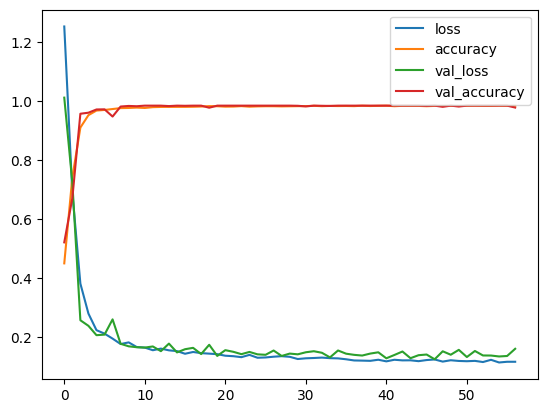

In [13]:
pd.DataFrame(loss.history).plot()

<Axes: >

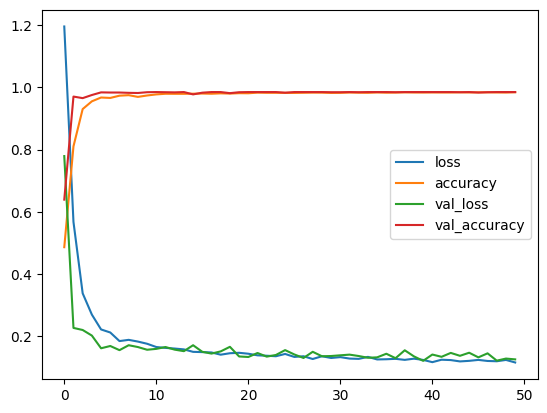

In [22]:
pd.DataFrame(loss.history).plot()

In [18]:
pred = model.predict(X_test).argmax(axis=1)
print('Accuracy on test set - {0:.02%}'.format((pred == y_test).mean()))

63/63 [==============================] - 0s 2ms/step
Accuracy on test set - 98.50%


In [19]:
pd.DataFrame(confusion_matrix(y_test, pred)).style.background_gradient(axis=None)

,0,1,2,3,4
0,308,0,0,2,2
1,0,557,2,2,0
2,3,4,365,0,0
3,2,3,2,428,2
4,1,1,1,3,312


In [23]:
model.save("edgzur.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
